<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

## Implement Resnet from scrach in Pytorch

ResnNet paper: https://arxiv.org/pdf/1512.03385

## ConvBlock

First we will implement ConvBlock class. Simple class which wraps Conv2d and BatchNormalization.

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.bn(self.conv1(x))

In [ ]:
test = torch.rand((3, 3, 224, 224))
cb = ConvBlock(3, 64, 3, 2, 1)

print(f'Shape: {cb(test).shape}')

Shape: torch.Size([3, 64, 112, 112])


## Residual block

Residual block contains 3 or more ConvBlocks(Conv2d + BachNorm2d) with ReLU activation after each without the last and and the end it returns inputs + computed from block, activated with ReLU.

The other name of Residual Block is **BottleNeck**

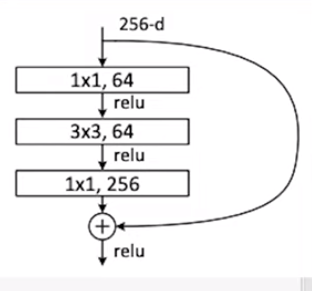


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, is_first=False):
    super().__init__()

    # So the input channels are 256 and conv channels are 64, which is 256 / 4
    res_channels = in_channels // 4

    self.p = None

    stride = 1
    if in_channels != out_channels:
      # With stride = 2, we downsample it, to match the dimension of the output we can add
      self.p = ConvBlock(in_channels, out_channels, kernel_size=1, stride=2, padding=0)
      stride = 2
      res_channels = in_channels // 2


    if is_first:
      self.p = ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
      stride = 1
      res_channels = in_channels

    self.conv1 = ConvBlock(in_channels=in_channels, out_channels=res_channels,
                           kernel_size=1, stride=1, padding=0)
    self.conv2 = ConvBlock(in_channels=res_channels, out_channels=res_channels,
                           kernel_size=3, stride=stride, padding=1)
    self.conv3 = ConvBlock(in_channels=res_channels, out_channels=out_channels,
                           kernel_size=1, stride=1, padding=0)
    self.relu = nn.ReLU()


  def forward(self, x):
    f = self.relu(self.conv1(x))
    f = self.relu(self.conv2(f))
    f = self.conv3(f)

    if self.p:
      # To match the dimentions before adding
      x = self.p(x)

    res = self.relu(torch.add(f, x))
    return res

In [ ]:
inp = torch.rand((32, 3, 224, 224))

first_resid = ResidualBlock(3, 64, True)
not_first_resid = ResidualBlock(3, 64, False)

print(f'First layer output: {first_resid(inp).shape}') # First layer returns the shape (num_samples, out_channels, heigth, width) because the stride is 1
print(f'Non First layer output: {not_first_resid(inp).shape}') # Non first returns (num_samples, out_channels, heigth / 2, width / 2) because the stride is 2


First layer output: torch.Size([32, 64, 224, 224])
Non First layer output: torch.Size([32, 64, 112, 112])


## Resnet

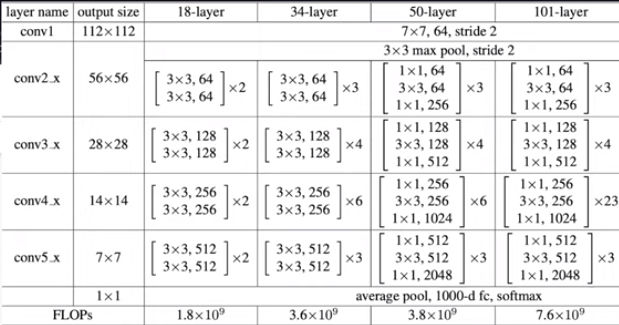


For every resnet variant we have different output features for a block. For example for 18-layer output features are 64, 128, 256 and 512. For 50-layer architecture they are 256, 512, 1024 and 2048. They are always starting from 1 point and double at each other.

In [ ]:


class ResNet(nn.Module):
  def __init__(self, num_blocks, out_features, in_channels=3, num_classes=1000):
    super().__init__()
    self.residual_blocks = nn.ModuleList([
        ResidualBlock(64, 256, is_first=True)
    ])

    for i in range(len(out_features)):
      if i > 0:
        self.residual_blocks.append(ResidualBlock(out_features[i-1], out_features[i]))
      for _ in range(num_blocks[i] - 1):
        self.residual_blocks.append(ResidualBlock(out_features[i], out_features[i]))

    self.conv1 = ConvBlock(in_channels=in_channels, out_channels=64,
                           kernel_size=7, stride=2, padding=3)
    self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc = nn.Linear(out_features[-1], num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.max_pool(x)
    for block in self.residual_blocks:
      x = block(x)

    x = self.avg_pool(x)

    x = torch.flatten(x, 1)

    x = self.fc(x)
    return x


In [ ]:
num_blocks = [3, 4, 6, 3]
out_features = [256, 512, 1024, 2048]

net = ResNet(num_blocks, out_features, num_classes=10)

inp = torch.rand((4, 3, 224, 224))

print(f'Result shape: {net(inp).shape}')

Result shape: torch.Size([4, 10])
